In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from calendar import day_name
from IPython.display import display, Markdown

from sklearn.model_selection import TimeSeriesSplit
from math import inf
from fbprophet import Prophet;

%matplotlib inline

pd.plotting.register_matplotlib_converters()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


# Step 0: prepare data set
***

In [2]:
df_stations = pd.read_csv('exercise_data/example_sprit_cut_station.csv',sep=';')

## Analysis of stations : Clean data

There are irrelevant columns and duplicates. Moreover, invalid values need to be dealt with.

In [3]:
cols_to_drop = ['VERSION','VERSION_TIME','HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER']
# Drop irrelevant columns
df_stations.drop(cols_to_drop,inplace=True,axis=1)

In [4]:
# Drop duplicates
df_stations.drop_duplicates(inplace=True)

In [5]:
# Replace Invalid Streets and Places
df_stations.update(df_stations[['STREET','PLACE']].fillna('Unknown'))

In [6]:
# Replace invalid entries in postcode
df_stations['POST_CODE'].fillna(value=0, inplace=True)
df_stations['POST_CODE'].replace(to_replace=['\\N'],value='0',inplace=True)
df_stations['POST_CODE'].replace(to_replace=['nicht'],value='0',inplace=True)

In [7]:
# Drop invalid brands
inactive_brands=df_stations[df_stations['BRAND']=='nicht mehr aktiv']
df_stations.drop(inactive_brands.index,axis=0,inplace=True)

In [8]:
# Replace NaN s and \\N s in brands
df_stations['BRAND'].fillna(value='No Brand', inplace= True)
df_stations['BRAND'].replace(to_replace=['\\N'],value='No Brand',inplace=True)

In [9]:
# Put brands and names in title case
df_stations['BRAND'] = df_stations['BRAND'].str.title()
df_stations['NAME'] = df_stations['NAME'].str.title()
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz Herxheim B.Ld.       Tanken An L.493', 'Auto Zotz Landau In Der Pfalz   Tanken Und Waschen', 'Avia', 'Bft', 'Classic', 'E Center', 'Eberhardt Jöhlingen', 'Ed', 'Elan', 'Esso', 'Frei', 'Freie', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'No Brand', 'Oil!', 'Omv', 'Preis', 'Raiffeisen', 'Raiffeisen Tankstelle', 'Rnt', 'Sb', 'Sb Markt', 'Sb-Markttankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'Supermarkt-Tankstelle', 'Supermarkt-Tankstelle Am Real- Markt', 'T', 'Tamoil', 'Tankcenter', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


In [10]:
# More brand cleaning
df_stations.replace({'BRAND' : { '^Auto Zotz.*' : 'Auto Zotz', 
                                           '^Frei.*' : 'Freie Tankstelle',
                                           '^Raiffeisen.*' : 'Raiffeisen Tankstelle',
                                           '^Sb.*' : 'Sb Markt Tankstelle',
                                           '^Supermarkt.*' : 'Supermarkt Tankstelle'
                                            }},regex=True,inplace=True)
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Avia', 'Bft', 'Classic', 'E Center', 'Eberhardt Jöhlingen', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'No Brand', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'T', 'Tamoil', 'Tankcenter', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


In [11]:
# 'No name' brand can be replaced by names
df_stations['BRAND']=np.where(df_stations['BRAND']== 'No Brand', df_stations['NAME'], df_stations['BRAND'])

#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Autohaus Holz Gmbh Landau', 'Autohaus Holz Gmbh Neustadt', 'Avia', 'Bft', 'Classic', 'Dudenhöffer & Rung Gmbh', 'E Center', 'Eberhardt Hardeckstraße Karlsruhe', 'Eberhardt Jöhlingen', 'Eberhardt Rastatter Straße Karlsruhe', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Bobenheim-Roxheim', 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Kaiserslautern', 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Grünstadt', 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Neustadt', 'Globus Handelshof Gmbh & Co.Kg Betriebsstätte Ludwigshafen-Oggersheim', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'Oel-Huff Gmbh Stefan Rudolph', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Sbk - Tankstelle', 'Sbk Selbstbedienungskauf Gmbh Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Sh

In [12]:
# Even more brand cleaning
df_stations.replace({'BRAND' : { '^Autohaus Holz.*' : 'Autohaus Holz', 
                                           '^Eberhardt.*' : 'Eberhardt',
                                           '^Globus Handelshof .*' : 'Globus Handelshof Gmbh & Co. Kg',
                                           '^Sbk .*' : 'Sbk - Tankstelle',
                                            }},regex=True,inplace=True)
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Autohaus Holz', 'Avia', 'Bft', 'Classic', 'Dudenhöffer & Rung Gmbh', 'E Center', 'Eberhardt', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Globus Handelshof Gmbh & Co. Kg', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'Oel-Huff Gmbh Stefan Rudolph', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Sbk - Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'T', 'Tamoil', 'Tankcenter', 'Tankcenter Ziehl', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


In [13]:
df_prices = pd.read_csv('exercise_data/example_sprit_cut_prices.csv',sep=';')

## Analysis of prices : Clean data
We see that there are invalid prices along with duplicates. We need to normalise the dataset firstly and then perform the analysis

In [14]:
# Drop duplicates
df_prices.drop_duplicates(inplace=True)


In [15]:
# Remove invalid prices from the data
def remove_invalid_prices(fuel_name):
    fuel_invalid=df_prices[df_prices[fuel_name]<=0]
    df_prices.drop(fuel_invalid.index,axis=0,inplace=True)

remove_invalid_prices('E5')
remove_invalid_prices('E10')
remove_invalid_prices('DIESEL')

In [16]:
df_prices.describe()

,E5,E10,DIESEL,CHANGED
count,1.075425e+06,1.075425e+06,1.075425e+06,1.075425e+06
mean,1.457085e+03,1.429118e+03,1.247725e+03,1.900296e+01
std,1.045053e+02,9.922577e+01,1.024969e+02,7.726616e+00
min,8.000000e+00,1.000000e+03,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.430000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.319000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


We see that the max, min are quite unrealistically bad. This needs normalisation

In [17]:
def normalise_data(fuel_name):
    data_mean, data_std = df_prices[fuel_name].mean(), df_prices[fuel_name].std()
    # identify outliers upto 3 standard deviations
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    df_prices[fuel_name]=np.where(np.logical_or(df_prices[fuel_name] <
                                                lower,df_prices[fuel_name] > upper), 
                                  df_prices[fuel_name].median(), 
                                  df_prices[fuel_name])

normalise_data('E5')
normalise_data('E10')
normalise_data('DIESEL')

In [18]:
df_stations.sample()

,ID,NAME,BRAND,STREET,POST_CODE,PLACE,LAT,LNG
614,afae9263-388f-4fdf-bac3-d9b8ec670937,Total Woerth,Total,PFORTZER STR.,76744,WOERTH,49.0383,8.289295


In [19]:
# Convert fuel prices to euro
for fuel in ('E5','E10','DIESEL'):
    df_prices[fuel] = df_prices[fuel]/1000

# Save dates in standard format
df_prices['DATE_CHANGED'] = pd.to_datetime(df_prices['DATE_CHANGED'])

### Merging data

In [20]:
df_stations.rename(columns={'ID':'STID'}, inplace=True)

In [21]:
merged_df= pd.merge(df_prices,df_stations, on='STID')

In [22]:
no_of_stations = merged_df.STID.nunique()
no_of_brands = merged_df.BRAND.nunique()
display(Markdown('### There are '+str(no_of_stations)+' stations belonging to '+str(no_of_brands)+' brands'))

### There are 399 stations belonging to 46 brands

In [23]:
# We assume brand history in the specified data is the existing history
station_existence = merged_df.groupby('STID')['NAME','DATE_CHANGED']
st_start=station_existence.min().reset_index()
st_end=station_existence.max().reset_index()
# get brand history in days and 
brand_history = (pd.to_datetime(st_end['DATE_CHANGED'])-pd.to_datetime(st_start['DATE_CHANGED'])).dt.days
st_end['No of Days'] = brand_history

### Select 100 gas stations having the longest time history

In [24]:
st_group = st_end.groupby('No of Days')

In [25]:
st_group['STID'].count()

No of Days
82       1
126      1
153      1
172      1
290      1
293      1
348      1
351      1
390      1
394      1
396      1
404      1
406      1
439      1
455      1
457      1
459      2
462      1
464      1
469      1
471      1
472      1
475      1
476      6
477     40
478    329
Name: STID, dtype: int64

In [26]:
max_idx = st_group['STID'].count().idxmax()
max_idx

478

In [27]:
top_st_list = (st_group.get_group(max_idx)['STID'][:100]).to_list()


In [28]:
top_3_list = top_st_list[0:3]

In [29]:
merged_df_top100 = merged_df[merged_df.STID.isin(top_st_list)]

In [30]:
merged_df_top3 = merged_df[merged_df.STID.isin(top_3_list)]

In [31]:
filtered_merged_3 = merged_df_top3.drop(['CHANGED','STREET','POST_CODE','PLACE','LAT','LNG'],axis=1)

In [32]:
filtered_merged_100 = merged_df_top100.drop(['CHANGED','STREET','POST_CODE','PLACE','LAT','LNG'],axis=1)

### Align all data to ensure that they have all identical time horizon and steps

In [33]:
filtered_merged_100 = filtered_merged_100.set_index('DATE_CHANGED')
top_100_between_7_20 = filtered_merged_100.between_time('07:00', '20:00')

In [34]:
filtered_merged_3 = filtered_merged_3.set_index('DATE_CHANGED')
top_3_between_7_20 = filtered_merged_3.between_time('07:00', '20:00')

In [35]:
top_3_between_7_20 = top_3_between_7_20.groupby(top_3_between_7_20.index.date)['E5','E10','DIESEL'].mean()

In [36]:
top_100_between_7_20 = top_100_between_7_20.groupby(top_100_between_7_20.index.date)['E5','E10','DIESEL'].mean()

### Split dataframe into training and testing

In [37]:
training_df, testing_df = np.split(top_3_between_7_20, [int(.75*len(top_3_between_7_20))])

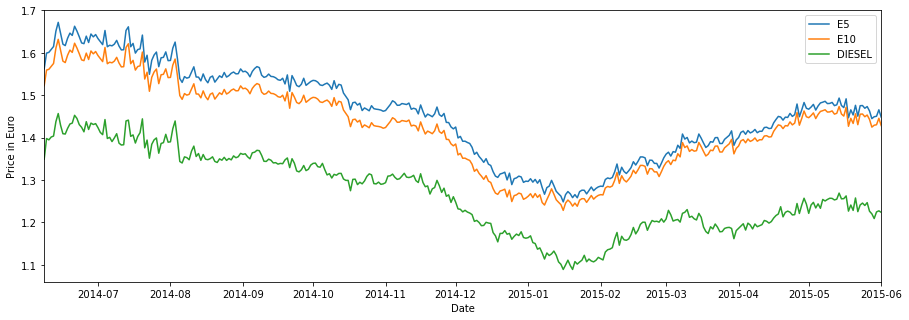

In [38]:
# Plot data
g = training_df.plot(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Price in Euro');

In [39]:
fuels = training_df.columns

# Step 1: Create simple reference model using simple moving average
***

In [40]:
#training_dfs[0] has indices and the rest of the data frames have the split data
training_dfs = np.split(training_df, np.arange(len(training_df.columns)), axis=1)
testing_dfs = np.split(testing_df, np.arange(len(testing_df.columns)), axis=1)

In [41]:
class RollingPredictor(object):
    def __init__(self,df,window_size=3):
        self.df_master = df.copy()
        self.df = self.df_master
        self.w = window_size
        
    def predict(self,date_to_predict):
        date_to_predict = pd.to_datetime(date_to_predict).date()
        latest_date_in_index = self.df.index.values[-1]
        first_date_in_index = self.df.index.values[0]
        # Calculate if the date is beyond the indices in data
        if date_to_predict > latest_date_in_index:
            # Get the missing dates
            num_missing_days = (date_to_predict-latest_date_in_index).days
            missing_dates = pd.date_range(end=date_to_predict,periods = num_missing_days)
            for day in missing_dates:                
                # Get window of values to calculate mean on
                w_days_before_date = pd.date_range(end=self.df.index[-1],periods = self.w)
                df_window = self.df[w_days_before_date[0]:w_days_before_date[-1]]
                column_name = (self.df.columns[0])
                rolling_mean = df_window.mean().values.item()
                result_frame = pd.DataFrame({column_name:rolling_mean},index=[day.date()])
                self.df = self.df.append(result_frame)
        # Return the first available data if the date is before the indices in data
        elif date_to_predict < first_date_in_index:
            date_to_predict = first_date_in_index
        return self.df[date_to_predict:date_to_predict].values.item()
    
    def train(self,training_list):
        self.w = len(training_list)
        self.df = self.df_master[training_list[0]:training_list[-1]]

In [42]:
def mean(value_list):
    return sum(value_list)/len(value_list)

def mean_absolute_deviation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100   

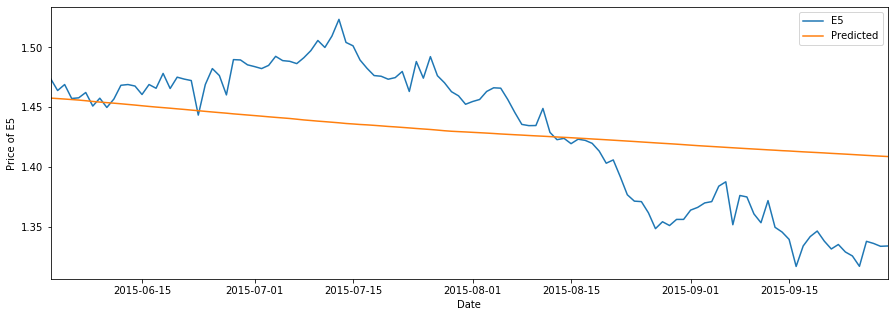

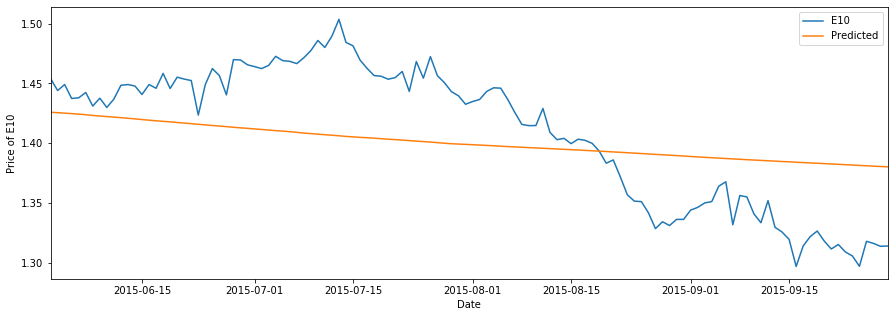

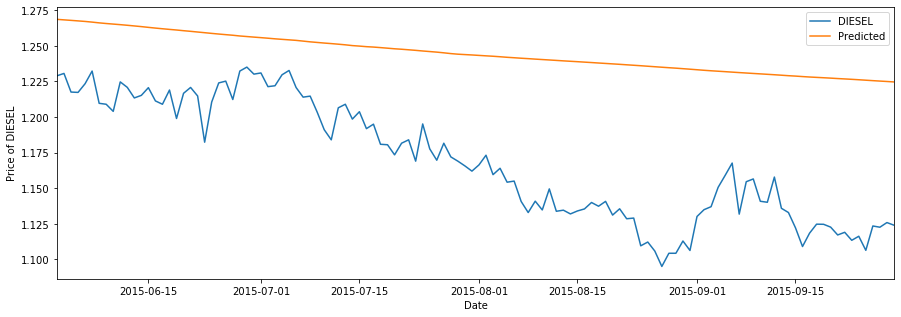

In [43]:
trained_predictors = []

# Cross validation and plotting
for fuel_train_df,fuel_test_df in zip(training_dfs[1:],testing_dfs[1:]):
    X = fuel_train_df.index.values
    fuel = fuel_train_df.columns[0]
    y = fuel_train_df[fuel].values
    num_values = len(fuel_train_df.index.values)
    tscv = TimeSeriesSplit(n_splits=num_values-1)

    rp = RollingPredictor(fuel_train_df)

    best_window_len = 1
    least_mean_metric = inf
    # Time split and Cross validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        window_len = len(X_train)    
        rp.train(X_train)
        y_hat = rp.predict(X_test.item())
        y_true = y_test.item()
        mad  = mean_absolute_deviation(y_true, y_hat)
        mape = mean_absolute_percentage_error(y_true, y_hat)
        # We need to minimise both metrics - this is equivalent to minimising the mean of the two
        mean_metric = mean([mad,mape])
        if mean_metric < least_mean_metric:
            best_window_len = window_len

    # Use the best window length for prediction
    trained_predictor = RollingPredictor(fuel_train_df,best_window_len)
    trained_predictors.append(trained_predictor)
    # Predict the values on test set
    test_dates = fuel_test_df.index.values
    predictions = [trained_predictor.predict(i) for i in test_dates]
    fuel_test_df['Predicted'] = predictions
    # Plot data
    p = fuel_test_df.plot(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Price of '+fuel)

# Step 2: Create Complex model using Prophet
***

In [44]:
# Make copies for use with prophet
training_sets = []
# The range present in training_dfs is 1-3 for the three fuels
for i,j in enumerate(range(1,4)):
    fuel_type = (training_dfs[j].columns.values.item())
    fuel_copy = training_dfs[j].copy()
    # Create a tuple of fuel,corresponding df
    fuel_copy.reset_index(level=0, inplace=True)
    # Rename columns for Prophet
    fuel_copy.columns = ['ds' , 'y']
    training_sets.append(fuel_copy)

In [45]:
prophets = []
for training_set in training_sets:
    # Create Prophet with seasonality in week, year and half year
    m = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
    m.fit(training_set)
    prophets.append(m)

/home/manjunath/miniconda2/envs/default/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [46]:
# Predict the future!
testing_dates = (testing_dfs[0].index.values)
first_day_test = testing_dates[0]
last_day_test = testing_dates[-1]
num_days_to_test = (last_day_test-first_day_test).days
#inclusive range
num_days_to_test += 1
futures = []
for prophet in prophets:
    futures.append(m.make_future_dataframe(periods=num_days_to_test))

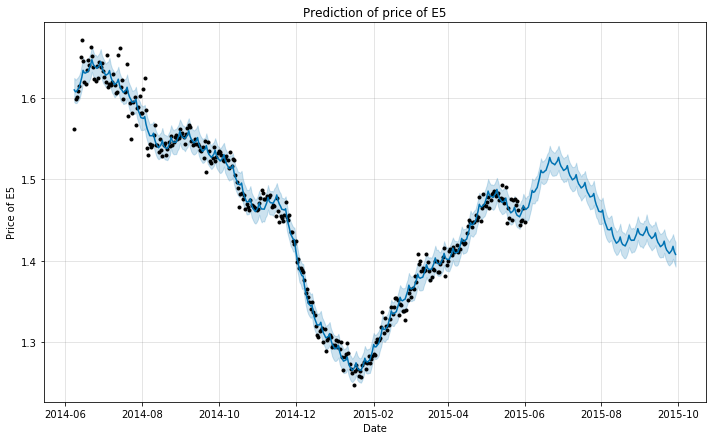

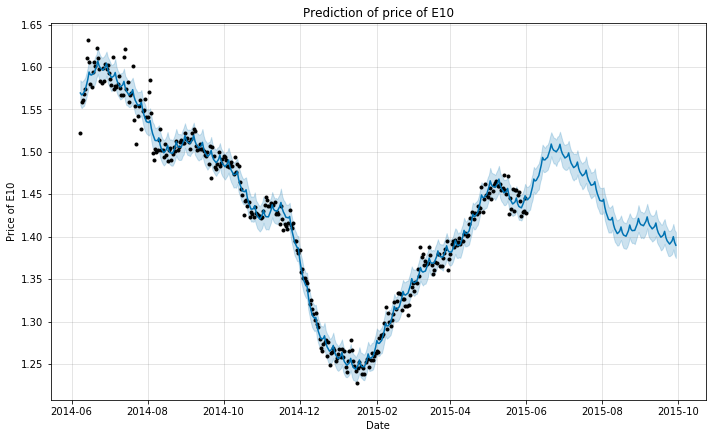

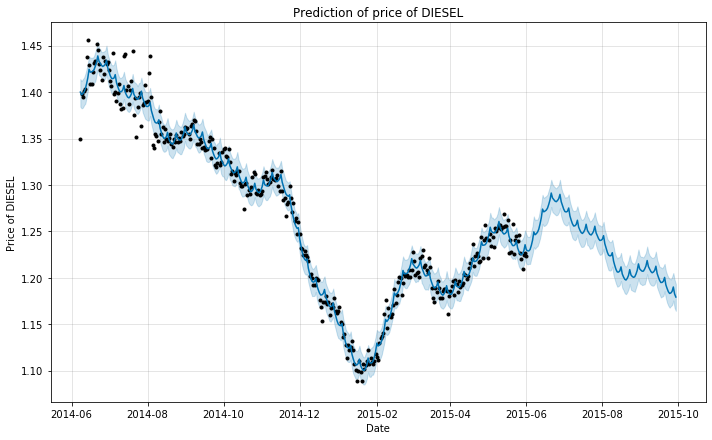

In [47]:
# Plot the future
forecasts = []
for fuel,prophet, future in zip(fuels,prophets, futures):
    forecast = prophet.predict(future)
    forecasts.append(forecast[['ds','yhat']])
        
    g = prophet.plot(forecast)

    plt.title('Prediction of price of '+fuel)
    plt.xlabel('Date')
    plt.ylabel('Price of '+fuel)
    
    

## Compare prediction result against the trivial reference model on MAD and MAPE

In [48]:
def plot_metrics(x_axis_data, y_axis_data_1,y_axis_data_2, plot_labels, plot_title, model_labels=['Reference model','Prophet']):
    # Plot two series for comparision
    label_1, label_2 = model_labels
    plt.figure(figsize=(15,5))
    x_label, y_label = plot_labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.plot (x_axis_data,y_axis_data_1,label=label_1)
    plt.plot (x_axis_data,y_axis_data_2,label=label_2)
    
    plt.legend(loc='best')

In [49]:
def compare_metrics(fuel_prices,predictions,prophet_predictions):
    # Trivial model results
    trivial_mad_list = [mean_absolute_deviation(true,pred) for true,pred in zip(fuel_prices,predictions)]
    trivial_mape_list = [mean_absolute_percentage_error(true,pred) for true,pred in zip(fuel_prices,predictions)]
       
    prophet_mad_list = [mean_absolute_deviation(true,pred) for true,pred in zip(fuel_prices,prophet_predictions)]
    prophet_mape_list = [mean_absolute_percentage_error(true,pred) for true,pred in zip(fuel_prices,prophet_predictions)]
    
    mad_plot = 'Mean Absolute Deviation of prediction of '+fuel_type
    plot_metrics(testing_dates,
                 trivial_mad_list,prophet_mad_list,
                 plot_labels=('Date','Mean Absolute Deviation'),plot_title = mad_plot)

    mape_plot = 'Mean Absolute Percentage Error of prediction of '+fuel_type
    plot_metrics(testing_dates,
                 trivial_mape_list,prophet_mape_list,
                 plot_labels=('Date','Mean Absolute Percentage Error'),plot_title = mape_plot)

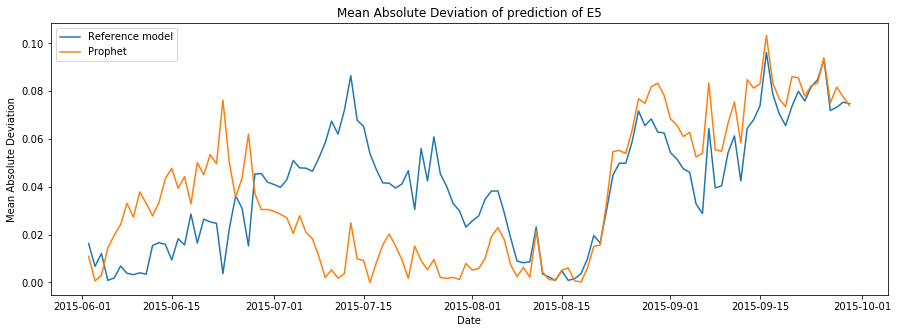

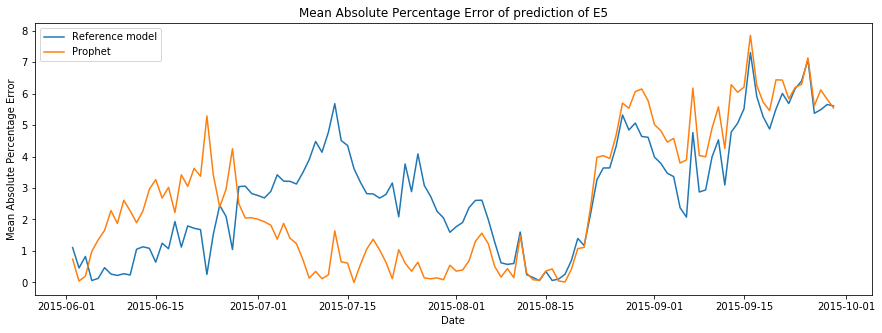

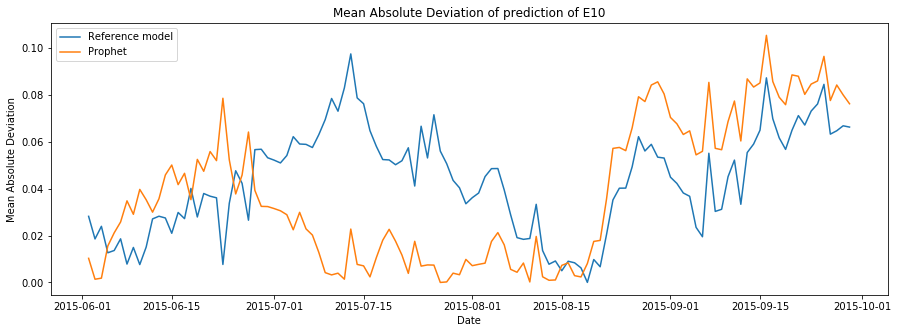

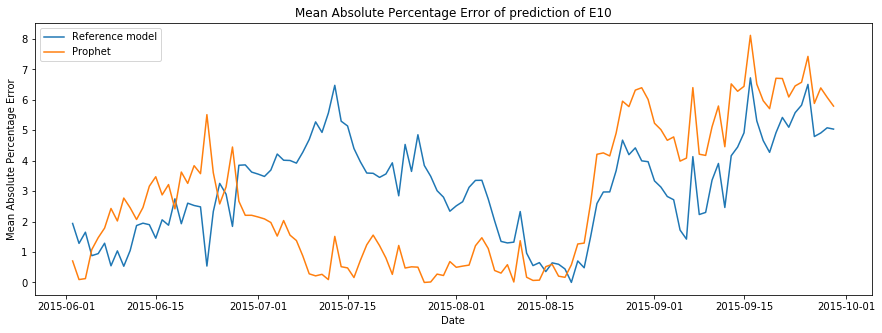

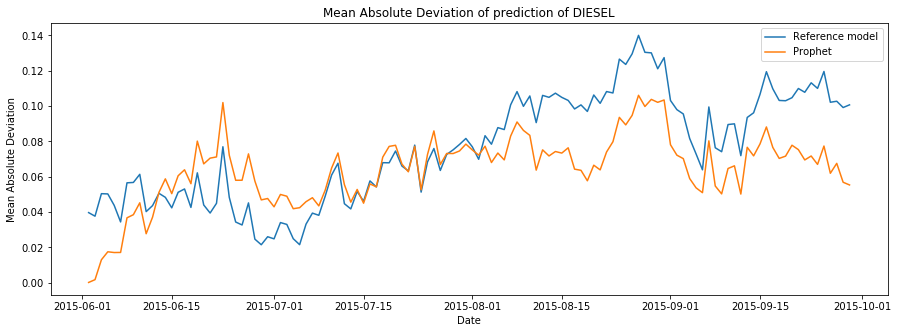

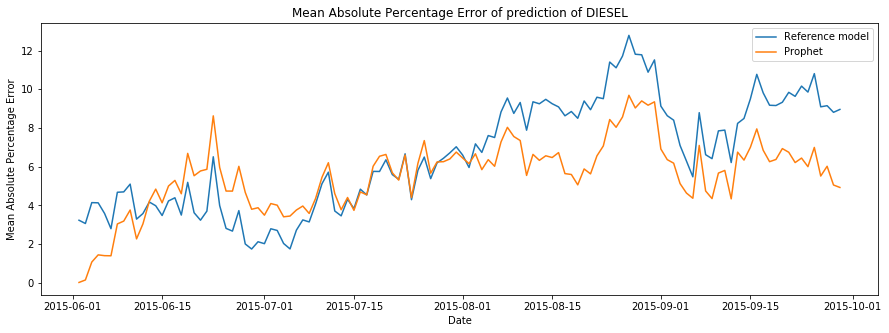

In [50]:
# Calculate MAD and MAPE s of the models
predictions_list = []
prophet_predictions_list = []
for fuel_i, i in enumerate(range(1,4)):
    # Trivial results
    
    fuel_type = (testing_dfs[i].columns.values)[0]
    predicted = (testing_dfs[i].columns.values)[1]
    fuel_prices = testing_dfs[i][fuel_type].values
    predictions = testing_dfs[i][predicted].values
    predictions_list.append(predictions)
    
    # Prophet results
    
    prophet_frame = forecasts[fuel_i]
    dates_frame = (prophet_frame['ds'])
    mask = ((dates_frame >= pd.Timestamp(first_day_test)) & (dates_frame <= pd.Timestamp(last_day_test)))
    prophet_predictions = (prophet_frame.loc[mask]['yhat'].values)
    prophet_predictions_list.append(prophet_predictions)
    
    compare_metrics(fuel_prices, predictions, prophet_predictions)
    
    

## It can be seen that Prophet's predictions over the period get better although they falter at times

# Step 3: Compare results of the two models on complete dataset
***

In [51]:
_,test_top_100 = np.split(top_100_between_7_20, [int(.75*len(top_100_between_7_20))])

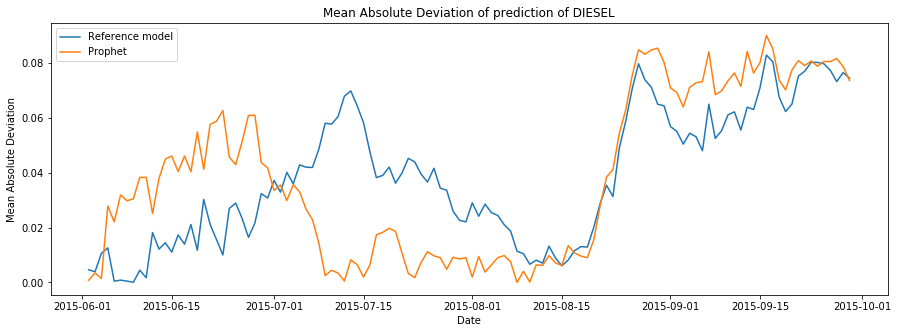

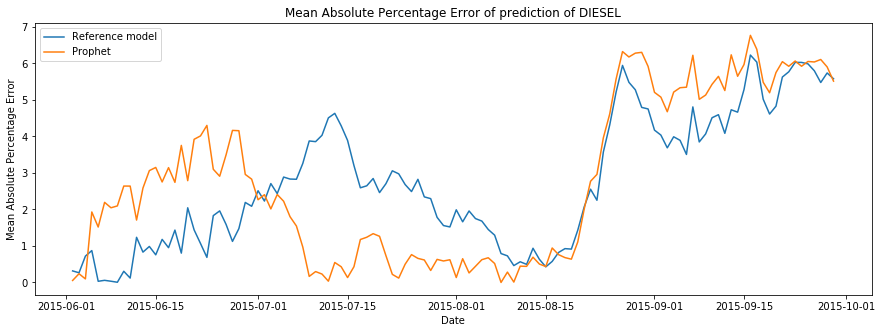

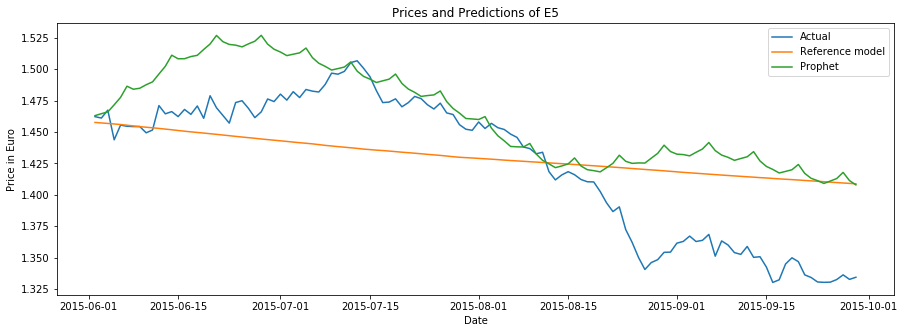

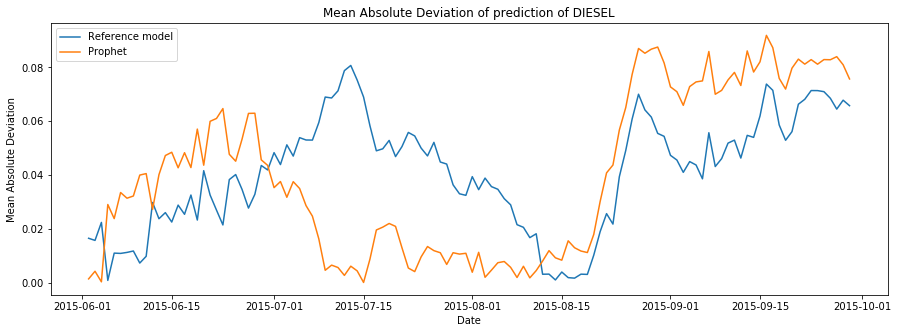

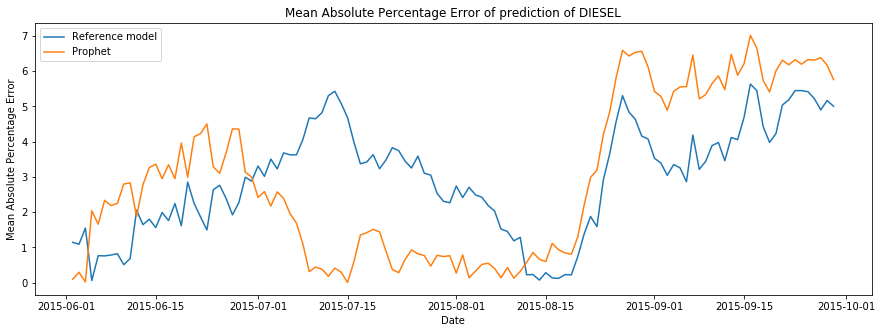

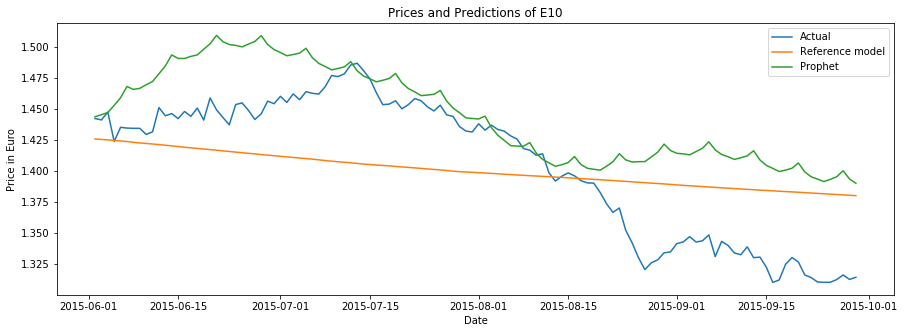

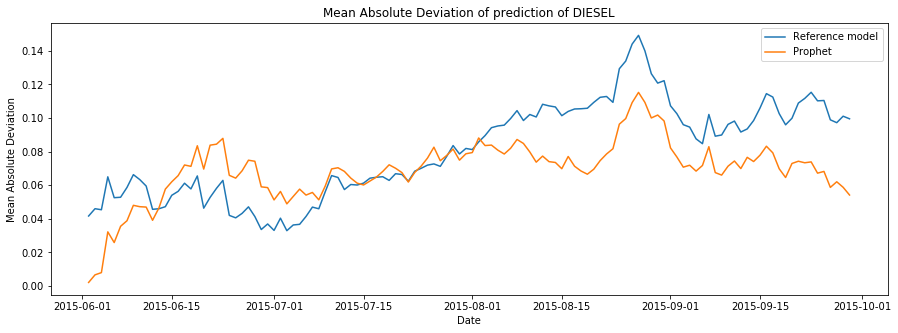

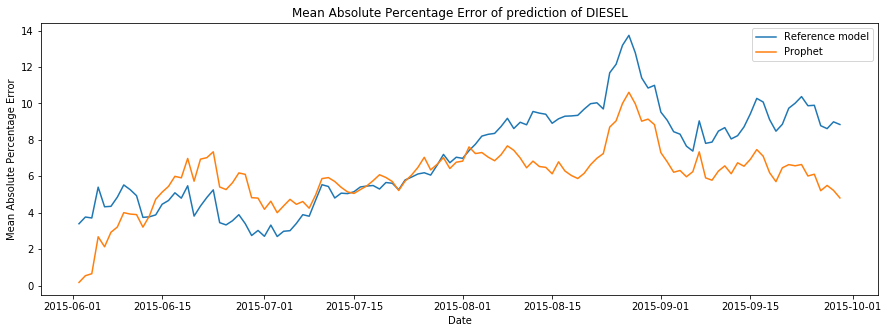

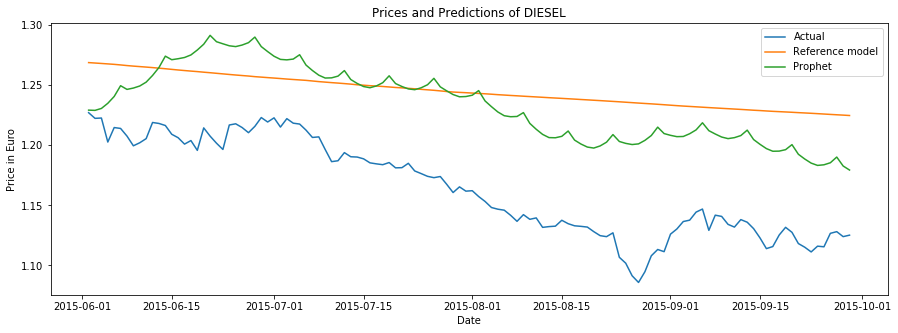

In [52]:
# Compare the predictions with the values in the full 100 stations' test dataset

for fuel, predictions, prophet_predictions in zip(fuels,predictions_list, prophet_predictions_list):
    fuel_prices = test_top_100[fuel]
    compare_metrics(fuel_prices, predictions, prophet_predictions)
    
    # Plot the prices against predictions
    plt.figure(figsize=(15,5))
    x_label, y_label = ('Date','Price in Euro')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Prices and Predictions of '+fuel)
    plt.plot (testing_dates,fuel_prices,label='Actual')
    plt.plot (testing_dates,predictions,label='Reference model')
    plt.plot (testing_dates,prophet_predictions,label='Prophet')
    plt.legend(loc='best')

# Unit tests

In [53]:
import unittest
import pandas as pd

def mean(value_list):
    return sum(value_list)/len(value_list)

def mean_absolute_deviation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100   


class TestMeanAndMetricMethods(unittest.TestCase):
    def test_mean(self):
        d = {'test1': [1, 3, 2, 4, 5, 6], 'test2': [9, 0, 1, 1, -4, 5]}
        df = pd.DataFrame(data=d)
        self.assertEqual(mean(df["test1"]), 3.5)
        self.assertEqual(mean(df["test2"]), 2.0)
    # Test mean_absolute_deviation
    def test_mad(self):
        d = {'test1': [[1,5,2,-1,10,3],[4,6,5,2,-7,-3]], 'test2': [[4,6,5,2,-7,-3],[4,6,-5,2,7,3]]}
        df = pd.DataFrame(data=d)
        self.assertEqual(mean_absolute_deviation(*df["test1"]), 5.5)
        self.assertEqual(mean_absolute_deviation(*df["test2"]), 5)
    # Test mean_absolute_percentage_error
    def test_mape(self):
        d = {'test1': [[1,5,2,-1,10,3],[4,6,5,2,-7,-3]], 'test2': [[4,6,5,2,-7,-3],[4,6,-5,2,7,3]]}
        df = pd.DataFrame(data=d)
        self.assertEqual(mean_absolute_percentage_error(*df["test1"]), 190)
        self.assertEqual(mean_absolute_percentage_error(*df["test2"]), 100)


unittest.main(argv=[''], verbosity=2, exit=False);

test_mad (__main__.TestMeanAndMetricMethods) ... ok
test_mape (__main__.TestMeanAndMetricMethods) ... ok
test_mean (__main__.TestMeanAndMetricMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK
